# Peruvian GDP Nowcasting - RIDGE

The present document has the objective to perform Peruvian GDP nowcasting using RIDGE regression with a rolling window approach to assess the out-sample performance.

Writen by [José Diego Gallardo](https://josediegogallardo.github.io/), based in [Fetsami Araya](https://github.com/Fetsami-Araya)'s `nowcast_ml.py` script.

## Outline
- <a href='#lib'>1. Required Libraries</a>
- <a href='#user'>2. Information to be defined by user</a>
- <a href='#data_preprop'>3. Data preprocessing</a>
- <a href='#lasso_rol'>4. RIDGE with rolling window</a>
- <a href='#results'>5. Results</a>

## <a id='lib'>1. Required Libraries</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning

import time
import os, warnings
from datetime import date
from datetime import datetime

start_time = datetime.now()

## <a id='user'>2. Information to be defined by user</a>

In [2]:
p = 6 # Number of lags per variable
h = 6 # Horizont for rolling window

## <a id='data_preprop'>3. Data preprocessing</a>

In [3]:
# Original database
df = pd.read_csv(r'.\gdp_data.csv')
df = df.set_index("dates")

# Working database
lags = range(1, p+1)
Z = df
Z = Z.assign(**{
    f'{col} (t-{lag})': Z[col].shift(lag)
    for lag in lags
    for col in Z
})
Z = Z.dropna()

# Exogenous and endogenous vectors
X = Z.loc[:, Z.columns != 'gdp']
y = Z["gdp"]

# Dates range
rw_date_range = pd.date_range(start=Z.index[-h-1], periods=h+1, freq  = 'MS')

# Iterable Date range
rw_date_range = rw_date_range.format()
rw_hor = len(rw_date_range)

## <a id='lasso_rol'>4. RIDGE with rolling window</a>

In [4]:
rmse = {}
y_act = {}
y_hat = {}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for i in range(1,rw_hor):

        X_train = X[:rw_date_range[i-1]]
        y_train = y[:rw_date_range[i-1]]
        X_test = X[rw_date_range[i]:rw_date_range[i]]
        y_test = y[rw_date_range[i]:rw_date_range[i]]

        ## Grid Search + time series cross-validation
        parameters = {'alpha':np.arange(0.01, 100, 1), # beta penalty parameter
                      'fit_intercept':[True], # Estimate intercept
                      'max_iter':[100000], # Number of iterations
                      'tol':[1e-8]} # Tolerance limit
        ridge = Ridge()
        ridge_cv = GridSearchCV(ridge,parameters, # Hyperparameters Gridsearch
                                cv=TimeSeriesSplit(n_splits=5)) # Time series cross-valdiation
        ridge_cv_fit = ridge_cv.fit(X_train,y_train)
        best_params = ridge_cv_fit.best_params_

        ## Lasso estimation with the best set of hyperparameter
        ridge_est = Ridge(alpha = best_params["alpha"],
                         fit_intercept = best_params["fit_intercept"],
                         max_iter = best_params["max_iter"],
                         tol = best_params["tol"]).fit(X_train,y_train)

        ## Lasso prediction
        y_hat_test = ridge_est.predict(X_test)

        ## Saving data
        y_act[rw_date_range[i]] = y_test.item()
        y_hat[rw_date_range[i]] = y_hat_test.item()

## <a id='results'>5. Results</a>

              actual  forecast
dates                         
2019-07-01  3.912189  3.859740
2019-08-01  3.697635  3.833005
2019-09-01  2.489750  3.468173
2019-10-01  2.678191  3.507918
2019-11-01  2.267064  2.591771
2019-12-01  1.153884  2.051859


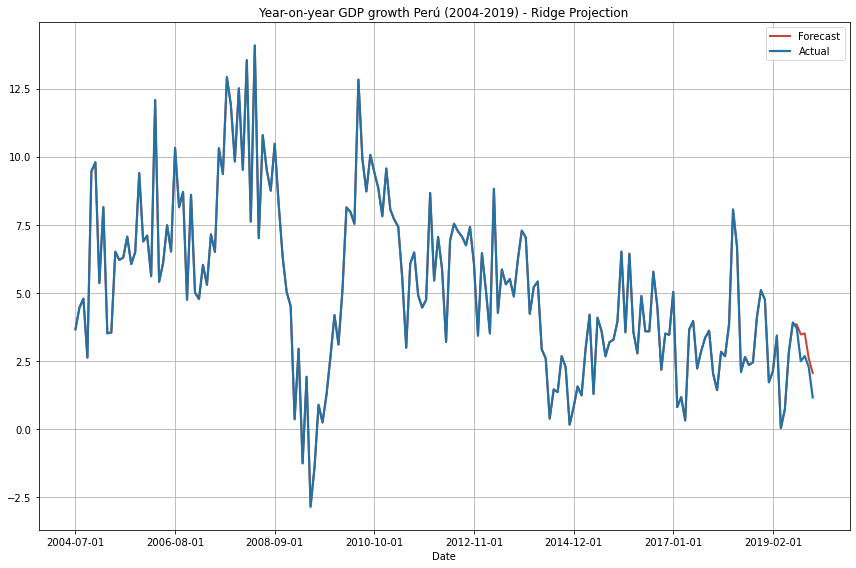

In [5]:
## Actual and proyection data
y_hat4plot = y.copy()

for i in range(1,rw_hor):
    y_hat4plot[rw_date_range[i]] = y_hat[rw_date_range[i]]

data = {"actual": y, 
        "forecast": y_hat4plot} 
df4plot = pd.concat(data, 
               axis = 1) 
print(df4plot.tail(h))

## Results plot
df4plot['forecast'].plot(figsize=[12,8],
                            color = '#CB4335',
                            linewidth=2,
                            label = 'Forecast')
df4plot['actual'].plot(figsize=[12,8],
                            color = '#2471A3',
                            linewidth=2.2,
                            label = 'Actual')
plt.xlabel('Date')
plt.title('Year-on-year GDP growth Perú (2004-2019) - Ridge Projection')
plt.grid(which='major')
plt.legend()
plt.tight_layout()

In [6]:
end_time = datetime.now()
print('Duracion: {}'.format(end_time - start_time))

Duracion: 0:00:09.670956
